<a href="https://colab.research.google.com/github/Smehta1234/Multi-Class-Classification-with-PyTorch/blob/main/make_blobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

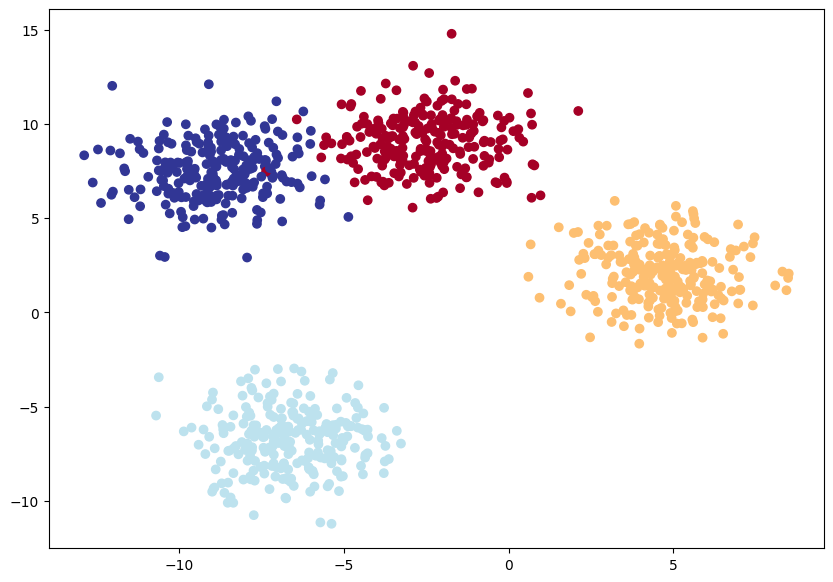

In [16]:
from inspect import currentframe
x_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            shuffle=True,
                            random_state=RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(x=x_blob[:, 0],
            y=x_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu);

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from torch import nn

In [19]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )


    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units = 8).to(device)
model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [20]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [21]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(x_blob_test.to(device))

In [22]:
y_preds_probs = torch.softmax(y_logits, dim=1)
y_preds_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')

In [23]:
y_preds = torch.argmax(y_preds_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [24]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

x_blob_train = x_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
x_blob_test = x_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(x_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(x_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% |Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.06362, Acc: 54.62% |Test Loss: 1.00386, Test Acc: 55.00%
Epoch: 10 | Loss: 0.62096, Acc: 97.25% |Test Loss: 0.63668, Test Acc: 98.00%
Epoch: 20 | Loss: 0.40612, Acc: 98.75% |Test Loss: 0.41038, Test Acc: 100.00%
Epoch: 30 | Loss: 0.23616, Acc: 99.12% |Test Loss: 0.22684, Test Acc: 99.50%
Epoch: 40 | Loss: 0.10442, Acc: 99.25% |Test Loss: 0.09487, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06402, Acc: 99.25% |Test Loss: 0.05627, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04968, Acc: 99.25% |Test Loss: 0.04191, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04243, Acc: 99.25% |Test Loss: 0.03429, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03799, Acc: 99.25% |Test Loss: 0.02949, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03501, Acc: 99.25% |Test Loss: 0.02637, Test Acc: 99.50%


In [30]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists')
else:
  print('Downloading helper_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [31]:
from helper_functions import plot_predictions, plot_decision_boundary


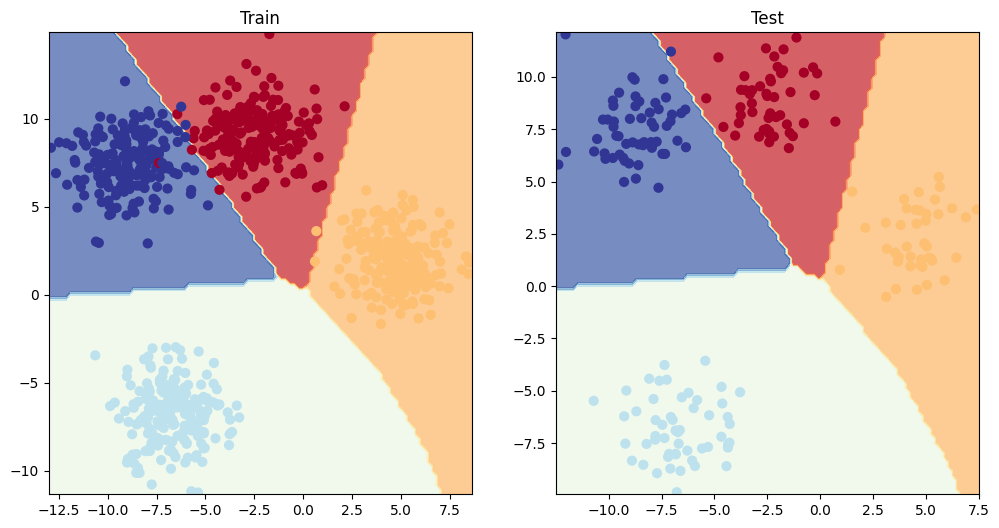

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, x_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, x_blob_test, y_blob_test)
